In [1]:
import torch
import torch.nn as nn
import torchvision
import torchsummary
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToTensor
from torchsummary import summary
from torch.nn.functional import relu, log_softmax

In [2]:
data_train = torchvision.datasets.MNIST('./../data',
        download=True,train=True,transform=ToTensor())
data_test = torchvision.datasets.MNIST('./../data',
        download=True,train=False,transform=ToTensor())

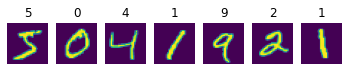

In [3]:
fig,ax = plt.subplots(1,7)
for i in range(7):
    ax[i].imshow(data_train[i][0].view(28,28))
    ax[i].set_title(data_train[i][1])
    ax[i].axis('off')

In [4]:
data_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./../data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
data_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./../data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
print('Training samples:',len(data_train))
print('Test samples:',len(data_test))

print('Tensor size:',data_train[0][0].size())
print('First 10 digits are:', [data_train[i][1] for i in range(10)])

Training samples: 60000
Test samples: 10000
Tensor size: torch.Size([1, 28, 28])
First 10 digits are: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [7]:
print('Min intensity value: ',data_train[0][0].min().item())
print('Max intensity value: ',data_train[0][0].max().item())

Min intensity value:  0.0
Max intensity value:  1.0


In [8]:
import pytorchcv2

In [9]:
from pytorchcv2 import load_mnist, plot_results

In [10]:
load_mnist()

0it [00:00, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


0it [00:00, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw


0it [00:00, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw


0it [00:00, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw
Processing...


C:\Users\sroy\Anaconda3\envs\torch\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [10]:
batch_size = 64
data_train = torchvision.datasets.MNIST('./../data',
        download=True,train=True,transform=ToTensor())
data_test = torchvision.datasets.MNIST('./../data',
        download=True,train=False,transform=ToTensor())
train_loader = torch.utils.data.DataLoader(data_train,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(data_test,batch_size=batch_size)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [12]:
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(28*28,10), # 784 inputs, 10 outputs
        nn.LogSoftmax())

net = net.to(device)

In [13]:
print('Digit to be predicted: ',data_train[0][1])
torch.exp(net(data_train[0][0].to(device)))

Digit to be predicted:  5


C:\Users\sroy\Anaconda3\envs\torch\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[0.1005, 0.1077, 0.0776, 0.1000, 0.0931, 0.0829, 0.1212, 0.1218, 0.1246,
         0.0706]], device='cuda:0', grad_fn=<ExpBackward>)

In [14]:
def train_epoch(net,dataloader,lr=0.001,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for data in dataloader:
        features, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out,labels) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==labels).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

train_epoch(net,train_loader)    

(0.008635980224609374, 0.8661333333333333)

In [15]:
def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for data in dataloader:
            features, labels = data[0].to(device), data[1].to(device)
            out = net(features)
            loss += loss_fn(out,labels) 
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

validate(net,test_loader)

(0.005281935882568359, 0.9086)

In [16]:
def train(net,train_loader,test_loader,optimizer=None,lr=0.001,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

In [37]:
# Re-initialize the network to start from scratch
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,10), # 784 inputs, 10 outputs
        nn.LogSoftmax())

net = net.to(device)
hist = train(net,train_loader,test_loader,epochs=5)

Epoch  0, Train acc=0.868, Val acc=0.908, Train loss=0.009, Val loss=0.005
Epoch  1, Train acc=0.909, Val acc=0.917, Train loss=0.005, Val loss=0.005
Epoch  2, Train acc=0.917, Val acc=0.920, Train loss=0.005, Val loss=0.004
Epoch  3, Train acc=0.920, Val acc=0.922, Train loss=0.004, Val loss=0.004
Epoch  4, Train acc=0.923, Val acc=0.924, Train loss=0.004, Val loss=0.004


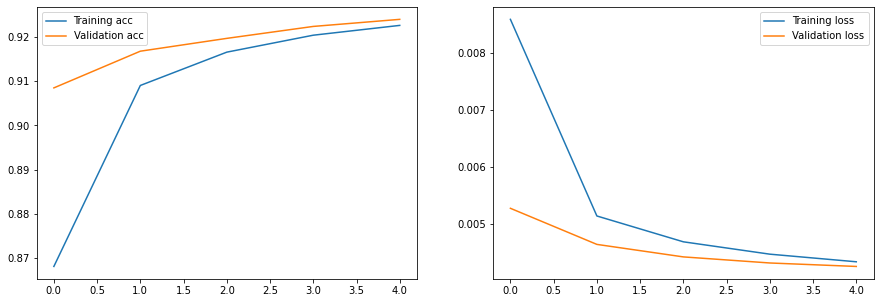

In [38]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist['train_acc'], label='Training acc')
plt.plot(hist['val_acc'], label='Validation acc')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend()

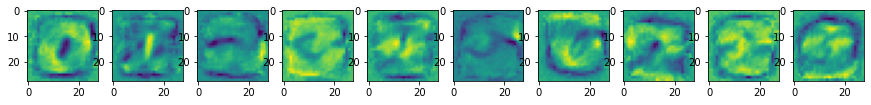

In [40]:
weight_tensor = next(net.parameters())

fig,ax = plt.subplots(1,10,figsize=(15,4))

for i,x in enumerate(weight_tensor):
    ax[i].imshow(x.view(28,28).cpu().detach())

In [41]:
weight_tensor.size()

torch.Size([10, 784])

In [42]:
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,100),     # 784 inputs, 100 outputs
        nn.ReLU(),              # Activation Function
        nn.Linear(100,10),      # 100 inputs, 10 outputs
        nn.LogSoftmax(dim=0))

net = net.to(device)
summary(net,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
              ReLU-3                  [-1, 100]               0
            Linear-4                   [-1, 10]           1,010
        LogSoftmax-5                   [-1, 10]               0
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.30
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [43]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(784,100)
        self.out = nn.Linear(100,10)
        self.log_soft_max = nn.LogSoftmax(dim=0)

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden(x)
        x = relu(x)
        x = self.out(x)
        x = self.log_soft_max(x)
        return x

net = MyNet()

net = net.to(device)
summary(net,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
            Linear-3                   [-1, 10]           1,010
        LogSoftmax-4                   [-1, 10]               0
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.30
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


Epoch  0, Train acc=0.908, Val acc=0.944, Train loss=0.037, Val loss=0.034
Epoch  1, Train acc=0.951, Val acc=0.957, Train loss=0.033, Val loss=0.033
Epoch  2, Train acc=0.962, Val acc=0.964, Train loss=0.033, Val loss=0.032
Epoch  3, Train acc=0.969, Val acc=0.967, Train loss=0.032, Val loss=0.032
Epoch  4, Train acc=0.973, Val acc=0.969, Train loss=0.032, Val loss=0.032


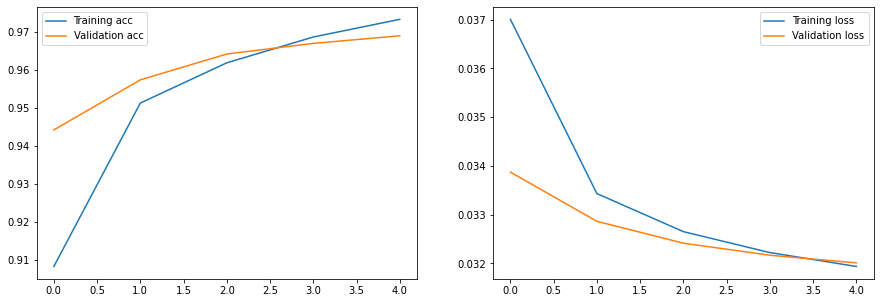

In [44]:
hist = train(net,train_loader,test_loader,epochs=5)
plot_results(hist)

In [48]:
#Convolutional neural networks

In [49]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

from pytorchcv2 import load_mnist, train, plot_results, plot_convolution, display_dataset
load_mnist(batch_size=128)

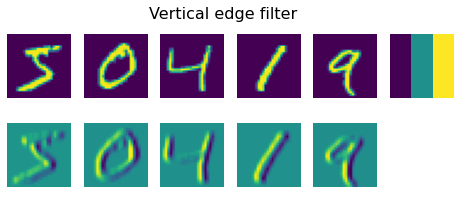

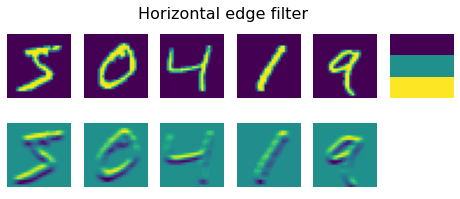

In [50]:
plot_convolution(torch.tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]]),'Vertical edge filter')
plot_convolution(torch.tensor([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]]),'Horizontal edge filter')

In [51]:
class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(5184,10)

    def forward(self, x):
        x = nn.functional.relu(self.conv(x))
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = OneConv()

net = net.to(device)
summary(net,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 24, 24]             234
           Flatten-2                 [-1, 5184]               0
            Linear-3                   [-1, 10]          51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.20
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


Epoch  0, Train acc=0.954, Val acc=0.963, Train loss=0.002, Val loss=0.002
Epoch  1, Train acc=0.978, Val acc=0.969, Train loss=0.001, Val loss=0.002
Epoch  2, Train acc=0.983, Val acc=0.976, Train loss=0.001, Val loss=0.002
Epoch  3, Train acc=0.985, Val acc=0.962, Train loss=0.001, Val loss=0.003
Epoch  4, Train acc=0.988, Val acc=0.974, Train loss=0.001, Val loss=0.002


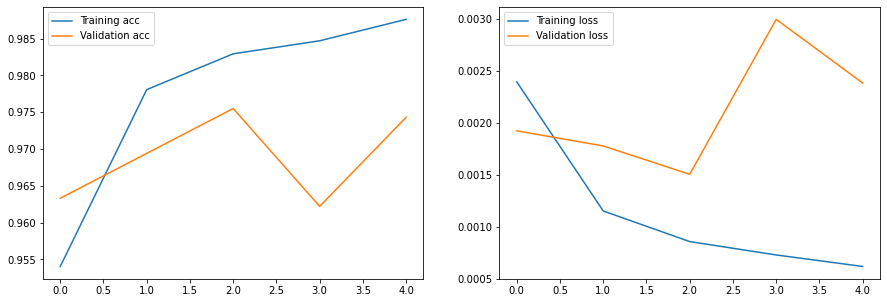

In [52]:
hist = train(net,train_loader,test_loader,epochs=5)
plot_results(hist)

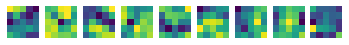

In [53]:
fig,ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

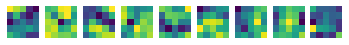

In [54]:
fig,ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

In [55]:
#Multi-Layered CNNs

In [56]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(320,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = MultiLayerCNN().to(device)

summary(net,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
         MaxPool2d-2           [-1, 10, 12, 12]               0
            Conv2d-3             [-1, 20, 8, 8]           5,020
         MaxPool2d-4             [-1, 20, 4, 4]               0
            Linear-5                   [-1, 10]           3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.03
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


In [57]:
hist = train(net,train_loader,test_loader,epochs=5)

Epoch  0, Train acc=0.953, Val acc=0.972, Train loss=0.002, Val loss=0.001
Epoch  1, Train acc=0.978, Val acc=0.980, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.981, Val acc=0.977, Train loss=0.001, Val loss=0.001
Epoch  3, Train acc=0.982, Val acc=0.979, Train loss=0.001, Val loss=0.001
Epoch  4, Train acc=0.983, Val acc=0.980, Train loss=0.001, Val loss=0.001


In [58]:
#CIFAR-10 dataset

In [59]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=14, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./../data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=14, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


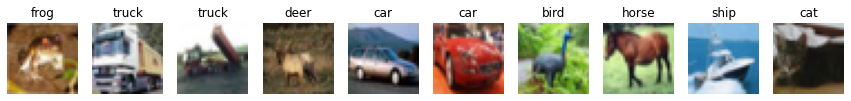

In [60]:
display_dataset(trainset,classes=classes)

In [61]:
#LeNet
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16,120,5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120,64)
        self.fc2 = nn.Linear(64,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = LeNet().to(device)

summary(net,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Conv2d-5            [-1, 120, 1, 1]          48,120
           Flatten-6                  [-1, 120]               0
            Linear-7                   [-1, 64]           7,744
            Linear-8                   [-1, 10]             650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


In [64]:
opt = torch.optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
hist = train(net, trainloader, testloader, epochs=3, optimizer=opt, loss_fn=nn.CrossEntropyLoss())
#hist = train(net, trainloader,testloader,epochs=5,loss_fn=nn.CrossEntropyLoss())

Epoch  0, Train acc=0.532, Val acc=0.551, Train loss=0.094, Val loss=0.092
Epoch  1, Train acc=0.568, Val acc=0.587, Train loss=0.087, Val loss=0.083
Epoch  2, Train acc=0.597, Val acc=0.607, Train loss=0.081, Val loss=0.080


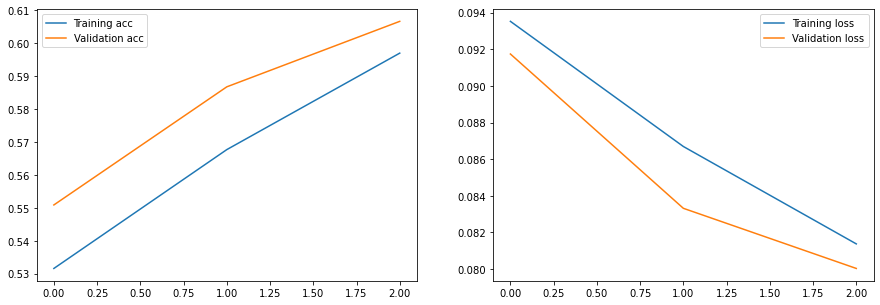

In [65]:
plot_results(hist)

In [1]:
#Use a pre-trained network with transfer learning

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
import os

from pytorchcv2 import train, plot_results, display_dataset, train_long, check_image_dir

In [3]:
check_image_dir('./../data/PetImages/Cat/*.jpg')
check_image_dir('./../data/PetImages/Dog/*.jpg')

C:\Users\sroy\Anaconda3\envs\torch\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
C:\Users\sroy\Anaconda3\envs\torch\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
C:\Users\sroy\Anaconda3\envs\torch\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
C:\Users\sroy\Anaconda3\envs\torch\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
C:\Users\sroy\Anaconda3\envs\torch\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
C:\U

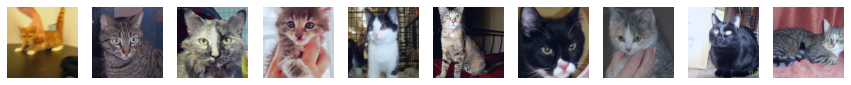

In [4]:
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        std_normalize])
dataset = torchvision.datasets.ImageFolder('./../data/PetImages',transform=trans)
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])

display_dataset(dataset)

In [40]:
vgg = torchvision.models.vgg16(pretrained=True)
sample_image = dataset[0][0].unsqueeze(0)
res = vgg(sample_image)
print(res[0].argmax())

tensor(282)


In [41]:
import json, requests

json_file_path = "./../data/imagenet_class_index.json"

with open(json_file_path, 'r') as j:
     class_map = json.loads(j.read())
        
class_map = { int(k) : v for k,v in class_map.items() }

class_map[res[0].argmax().item()]

['n02123159', 'tiger_cat']

In [42]:
vgg = vgg.to(device)
summary(vgg,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on device = {}'.format(device))

vgg.to(device)
sample_image = sample_image.to(device)

vgg(sample_image).argmax()

Doing computations on device = cuda


tensor(282, device='cuda:0')

torch.Size([1, 512, 7, 7])


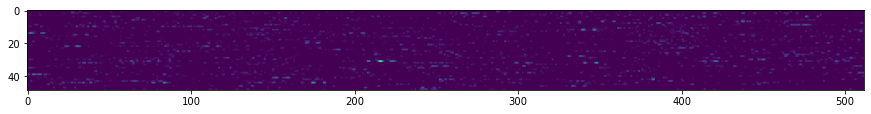

In [44]:
res = vgg.features(sample_image).cpu()
plt.figure(figsize=(15,3))
plt.imshow(res.detach().view(-1,512))
print(res.size())

In [45]:
bs = 8
dl = torch.utils.data.DataLoader(dataset,batch_size=bs,shuffle=True)
num = bs*100
feature_tensor = torch.zeros(num,512*7*7).to(device)
label_tensor = torch.zeros(num).to(device)
i = 0
for x,l in dl:
    with torch.no_grad():
        f = vgg.features(x.to(device))
        feature_tensor[i:i+bs] = f.view(bs,-1)
        label_tensor[i:i+bs] = l
        i+=bs
        print('.',end='')
        if i>=num:
            break

....................................................................................................

In [46]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor,label_tensor.to(torch.long))
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset,[700,100])

train_loader = torch.utils.data.DataLoader(train_ds,batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=32)

net = torch.nn.Sequential(torch.nn.Linear(512*7*7,2),torch.nn.LogSoftmax()).to(device)

history = train(net,train_loader,test_loader)

Epoch  0, Train acc=0.916, Val acc=0.970, Train loss=0.057, Val loss=0.020


C:\Users\sroy\Anaconda3\envs\torch\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch  1, Train acc=0.987, Val acc=0.990, Train loss=0.011, Val loss=0.006
Epoch  2, Train acc=0.987, Val acc=0.980, Train loss=0.011, Val loss=0.016
Epoch  3, Train acc=0.991, Val acc=0.930, Train loss=0.006, Val loss=0.083
Epoch  4, Train acc=0.993, Val acc=0.990, Train loss=0.003, Val loss=0.001
Epoch  5, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.003
Epoch  6, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.003
Epoch  7, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.003
Epoch  8, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.003
Epoch  9, Train acc=1.000, Val acc=0.990, Train loss=0.000, Val loss=0.003


In [47]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [48]:
vgg.classifier = torch.nn.Linear(25088,2).to(device)

for x in vgg.features.parameters():
    x.requires_grad = False

summary(vgg,(3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 244, 244]           1,792
              ReLU-2         [-1, 64, 244, 244]               0
            Conv2d-3         [-1, 64, 244, 244]          36,928
              ReLU-4         [-1, 64, 244, 244]               0
         MaxPool2d-5         [-1, 64, 122, 122]               0
            Conv2d-6        [-1, 128, 122, 122]          73,856
              ReLU-7        [-1, 128, 122, 122]               0
            Conv2d-8        [-1, 128, 122, 122]         147,584
              ReLU-9        [-1, 128, 122, 122]               0
        MaxPool2d-10          [-1, 128, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]         295,168
             ReLU-12          [-1, 256, 61, 61]               0
           Conv2d-13          [-1, 256, 61, 61]         590,080
             ReLU-14          [-1, 256,

In [49]:
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])
train_loader = torch.utils.data.DataLoader(trainset,batch_size=16)
test_loader = torch.utils.data.DataLoader(testset,batch_size=16)

train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.6875, train loss = 0.04669061303138733


C:\Users\sroy\Anaconda3\envs\torch\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
C:\Users\sroy\Anaconda3\envs\torch\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
C:\Users\sroy\Anaconda3\envs\torch\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
C:\Users\sroy\Anaconda3\envs\torch\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
C:\Users\sroy\Anaconda3\envs\torch\lib\site-packages\PIL\TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
C:\U

Epoch 0, minibatch 90: train acc = 0.9436813186813187, train loss = 0.12048645857926253
Epoch 0, minibatch 180: train acc = 0.9575276243093923, train loss = 0.11143900412880914
Epoch 0, minibatch 270: train acc = 0.9640221402214022, train loss = 0.11156893656262612
Epoch 0, minibatch 360: train acc = 0.9657202216066482, train loss = 0.1140877150432555
Epoch 0, minibatch 450: train acc = 0.9674334811529933, train loss = 0.11645586474771774
Epoch 0, minibatch 540: train acc = 0.9688077634011091, train loss = 0.11963670487324543
Epoch 0, minibatch 630: train acc = 0.9709786053882726, train loss = 0.11723918884567527
Epoch 0, minibatch 720: train acc = 0.9720873786407767, train loss = 0.11247256592474103
Epoch 0, minibatch 810: train acc = 0.9727188655980271, train loss = 0.1153816947513679
Epoch 0, minibatch 900: train acc = 0.9731548279689234, train loss = 0.12354257395211918
Epoch 0, minibatch 990: train acc = 0.9726286579212916, train loss = 0.13802108995608917
Epoch 0, minibatch 1080:

In [53]:
torch.save(vgg,'./../data/cats_dogs.pth')

In [54]:
vgg = torch.load('./../data/cats_dogs.pth')

In [55]:
for x in vgg.features.parameters():
    x.requires_grad = True

In [56]:
train_long(vgg,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90,lr=0.0001)

Epoch 0, minibatch 0: train acc = 1.0, train loss = 0.0
Epoch 0, minibatch 90: train acc = 0.8853021978021978, train loss = 0.29257822560740043
Epoch 0, minibatch 180: train acc = 0.9140193370165746, train loss = 0.1633588569598962
Epoch 0, minibatch 270: train acc = 0.9234317343173432, train loss = 0.11701612718870719
Epoch 0, minibatch 360: train acc = 0.9335180055401662, train loss = 0.09228320134973922
Epoch 0, minibatch 450: train acc = 0.9381929046563193, train loss = 0.0763703661324444
Epoch 0, minibatch 540: train acc = 0.9393484288354899, train loss = 0.06659120993340963
Epoch 0, minibatch 630: train acc = 0.9430467511885895, train loss = 0.05834803150497413
Epoch 0, minibatch 720: train acc = 0.945128294036061, train loss = 0.05206543265037166
Epoch 0, minibatch 810: train acc = 0.9475184956843403, train loss = 0.04714612572760529
Epoch 0, minibatch 900: train acc = 0.94915371809101, train loss = 0.043433275127516734
Epoch 0, minibatch 990: train acc = 0.9499243188698284, tra

In [57]:
resnet = torchvision.models.resnet18()
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [58]:
#Lightweight networks and MobileNet

In [59]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchsummary import summary
import os

from pytorchcv2 import train, display_dataset, train_long, load_cats_dogs_dataset, validate, common_transform

In [62]:
check_image_dir('./../data/PetImages/Cat/*.jpg')
check_image_dir('./../data/PetImages/Dog/*.jpg')

dataset = torchvision.datasets.ImageFolder('./../data/PetImages',transform=common_transform())
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])
trainloader = torch.utils.data.DataLoader(trainset,batch_size=32)
testloader = torch.utils.data.DataLoader(trainset,batch_size=32)

In [63]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
model.eval()
print(model)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to C:\Users\sroy/.cache\torch\hub\v0.6.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\sroy/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [64]:
sample_image = dataset[0][0].unsqueeze(0)
res = model(sample_image)
print(res[0].argmax())

tensor(285)


In [66]:
for x in model.parameters():
    x.requires_grad = False

In [68]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.classifier = nn.Linear(1280,2)
model = model.to(device)
summary(model,input_size=(3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 122, 122]             864
       BatchNorm2d-2         [-1, 32, 122, 122]              64
             ReLU6-3         [-1, 32, 122, 122]               0
            Conv2d-4         [-1, 32, 122, 122]             288
       BatchNorm2d-5         [-1, 32, 122, 122]              64
             ReLU6-6         [-1, 32, 122, 122]               0
            Conv2d-7         [-1, 16, 122, 122]             512
       BatchNorm2d-8         [-1, 16, 122, 122]              32
  InvertedResidual-9         [-1, 16, 122, 122]               0
           Conv2d-10         [-1, 96, 122, 122]           1,536
      BatchNorm2d-11         [-1, 96, 122, 122]             192
            ReLU6-12         [-1, 96, 122, 122]               0
           Conv2d-13           [-1, 96, 61, 61]             864
      BatchNorm2d-14           [-1, 96,

In [69]:
train_long(model,train_loader,test_loader,loss_fn=torch.nn.CrossEntropyLoss(),epochs=1,print_freq=90)

Epoch 0, minibatch 0: train acc = 0.3125, train loss = 0.058762840926647186
Epoch 0, minibatch 90: train acc = 0.8798076923076923, train loss = 0.028652704679048978
Epoch 0, minibatch 180: train acc = 0.9046961325966851, train loss = 0.02463894786097068
Epoch 0, minibatch 270: train acc = 0.9130535055350554, train loss = 0.02487978108254746
Epoch 0, minibatch 360: train acc = 0.917590027700831, train loss = 0.02406602949316812
Epoch 0, minibatch 450: train acc = 0.9235033259423503, train loss = 0.02294605957166583
Epoch 0, minibatch 540: train acc = 0.9265249537892791, train loss = 0.021968353257381983
Epoch 0, minibatch 630: train acc = 0.929675118858954, train loss = 0.0213169530152141
Epoch 0, minibatch 720: train acc = 0.9303051317614425, train loss = 0.021606195320203466
Epoch 0, minibatch 810: train acc = 0.9291769420468557, train loss = 0.023138518986072845
Epoch 0, minibatch 900: train acc = 0.9305632630410655, train loss = 0.023452760905986622
Epoch 0, minibatch 990: train acc